_Version log: Branch of V19. Trying out a new way of boundry checking and randomising the samples_

_Update: I resurrected V24 in order to make a nice graph demonstrating wide detectors._

In [134]:
import sys, warnings
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft as spfft
from scipy.constants import c as C
from tqdm import tqdm
import CS_functions as cs
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':24, 'xtick.minor.visible': True, 'ytick.minor.visible': False,
                     'xtick.direction': 'in', 'ytick.direction': 'in', "xtick.top": True, "ytick.right": True,
                     'lines.linewidth': 2.4, 'lines.markersize': 10.0, 'lines.markeredgewidth': 2.4})
np.set_printoptions(threshold=sys.maxsize)

In [135]:
file_name = "1dmockanderrors17"
file_type = ".csv"
pixel_pitch = 0.2 # in mm
theta = 200 # in arcmins

target, uncertainties = cs.open_dataset(file_name, file_type)
#uncertainties = np.ones_like(uncertainties)
total_points = len(target)
displacement = np.arange((1-total_points)//2, (1+total_points)//2, dtype= float)
displacement *= pixel_pitch
displacement = np.fft.fftshift(displacement)

displacement

array([  0. ,   0.2,   0.4,   0.6,   0.8,   1. ,   1.2,   1.4,   1.6,
         1.8,   2. ,   2.2,   2.4,   2.6,   2.8,   3. ,   3.2,   3.4,
         3.6,   3.8,   4. ,   4.2,   4.4,   4.6,   4.8,   5. ,   5.2,
         5.4,   5.6,   5.8,   6. ,   6.2,   6.4,   6.6,   6.8,   7. ,
         7.2,   7.4,   7.6,   7.8,   8. ,   8.2,   8.4,   8.6,   8.8,
         9. ,   9.2,   9.4,   9.6,   9.8,  10. ,  10.2,  10.4,  10.6,
        10.8,  11. ,  11.2,  11.4,  11.6,  11.8,  12. ,  12.2,  12.4,
        12.6,  12.8,  13. ,  13.2,  13.4,  13.6,  13.8,  14. ,  14.2,
        14.4,  14.6,  14.8,  15. ,  15.2,  15.4,  15.6,  15.8,  16. ,
        16.2,  16.4,  16.6,  16.8,  17. ,  17.2,  17.4,  17.6,  17.8,
        18. ,  18.2,  18.4,  18.6,  18.8,  19. ,  19.2,  19.4,  19.6,
        19.8, -20. , -19.8, -19.6, -19.4, -19.2, -19. , -18.8, -18.6,
       -18.4, -18.2, -18. , -17.8, -17.6, -17.4, -17.2, -17. , -16.8,
       -16.6, -16.4, -16.2, -16. , -15.8, -15.6, -15.4, -15.2, -15. ,
       -14.8, -14.6,

In [139]:
IRF_FWHM = 1.34 # in mm
sinc_FWHM = 3.790988534 /np.pi

IRF = 2*np.sinc(displacement *sinc_FWHM /IRF_FWHM)
IRF_FFT = np.fft.rfft(IRF, norm= "ortho")
IRF_spec = np.abs(IRF_FFT)

target_FFT = np.fft.rfft(target, norm= "ortho")
target_spec = np.abs(target_FFT)

convol_FFT = target_FFT *IRF_FFT
convol_spec = np.abs(convol_FFT)
convol = np.fft.irfft(convol_FFT, norm= "ortho")

wavenum = np.fft.rfftfreq(len(target), pixel_pitch) # in mm^-1
freqs = wavenum*10**3 * C / (2*np.sin(np.deg2rad(theta/60))) # in Hz
freqs *= 1e-12 # in THz

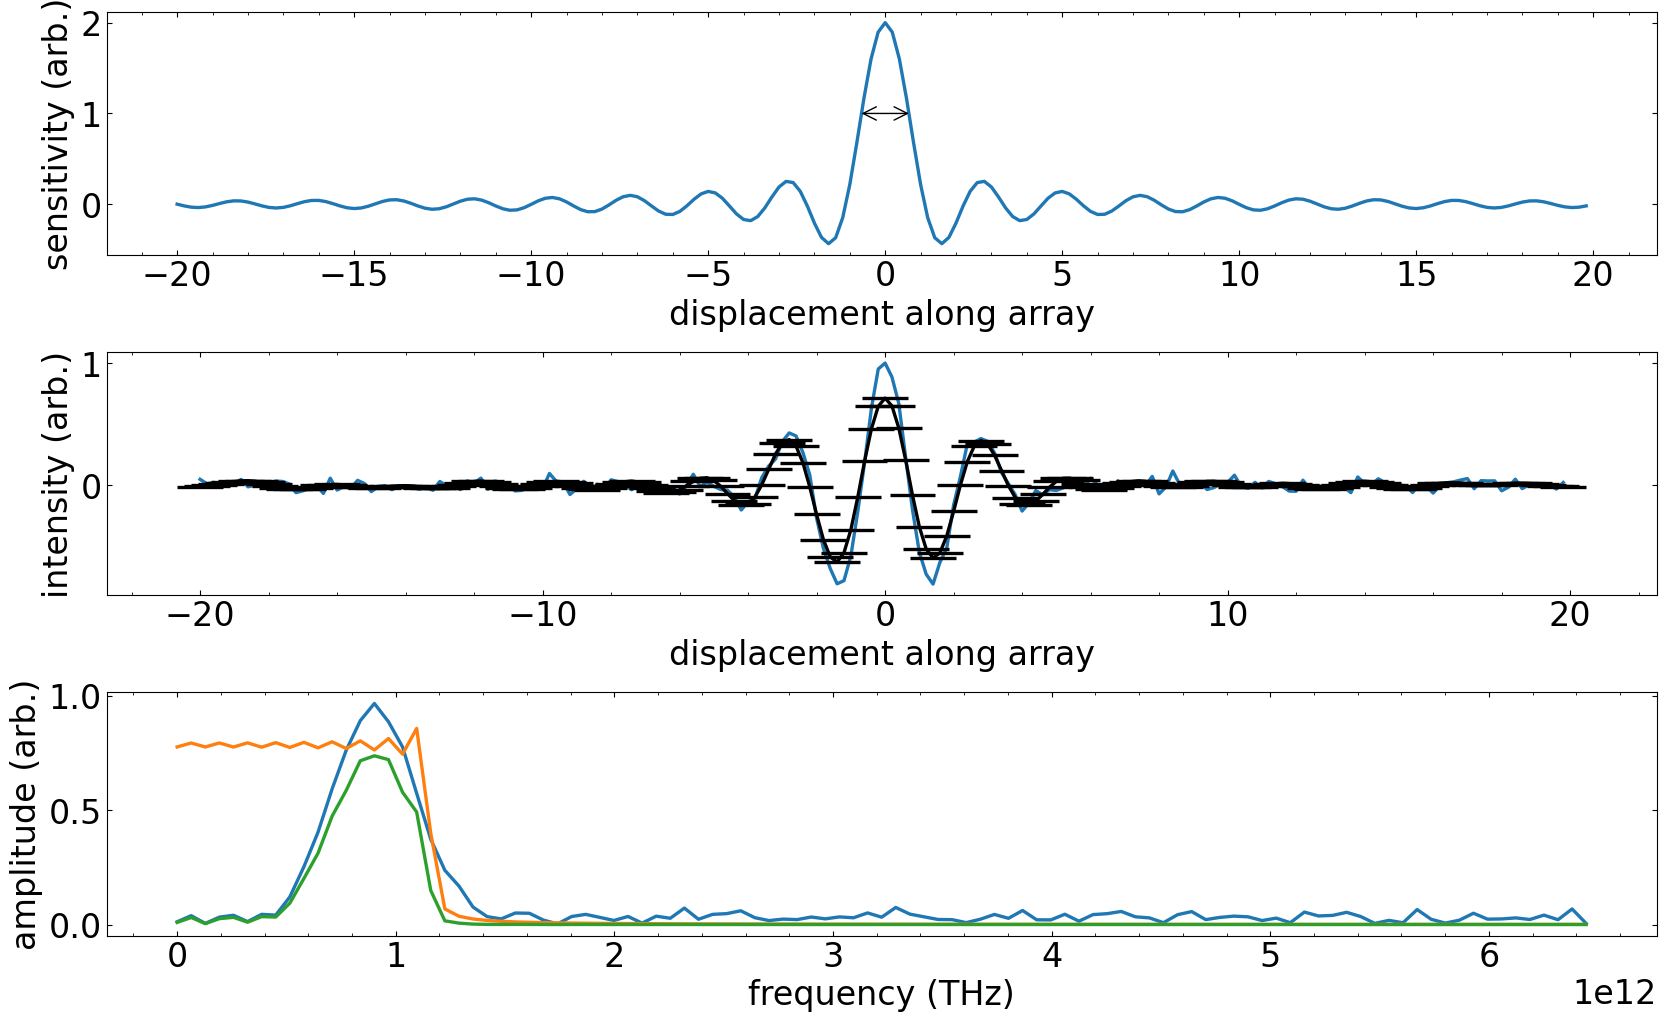

In [146]:

fig, axs = plt.subplots(3, 1, figsize= (20, 12), gridspec_kw= {"hspace": 0.4})

axs[0].plot(np.fft.ifftshift(displacement), np.fft.ifftshift(IRF))
axs[0].annotate("", xy= (-IRF_FWHM/2, 1), xytext= (IRF_FWHM/2, 1), arrowprops= {"arrowstyle": "<->", "shrinkA": 0, "shrinkB": 0})
axs[0].set(xlabel= "displacement along array", ylabel= "sensitivity (arb.)")

axs[1].plot(np.fft.ifftshift(displacement), target)
axs[1].errorbar(np.fft.ifftshift(displacement), convol, xerr= IRF_FWHM/2, color= "k")
axs[1].set(xlabel= "displacement along array", ylabel= "intensity (arb.)")

axs[2].plot(freqs, target_spec)
axs[2].plot(freqs, IRF_spec)
axs[2].plot(freqs, convol_spec)
axs[2].set(xlabel= "frequency (THz)", ylabel= "amplitude (arb.)")

plt.show()

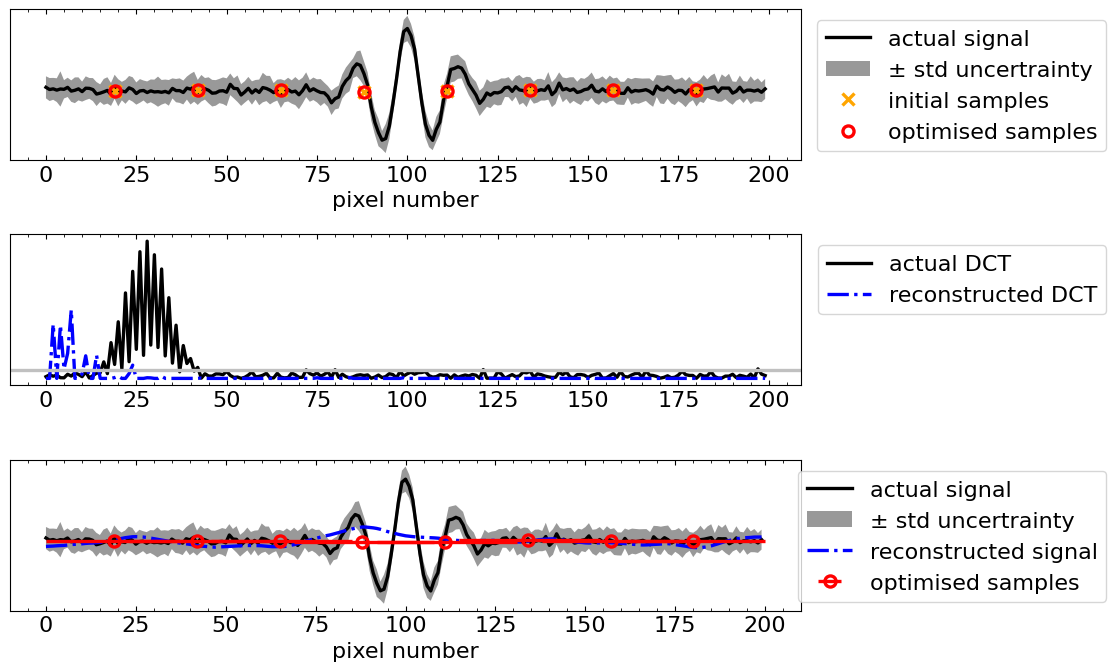

CS used 8 samples out of 52 needed to resolve the interferogram.
CS identified 8 out of 26 significant frequencies.


In [116]:
result_DCT = spfft.dct(result, norm= "forward")
target_DCT = spfft.dct(target, norm= "forward")

threshold = np.abs(target_DCT).mean()

plt.rcParams.update({'font.size':16})
fig, axs = plt.subplots(3,1, figsize= (12,7))

axs[0].plot(target, color= "k", label= "actual signal")
axs[0].fill_between(range(total_points), target-uncertainties, target+uncertainties, facecolor= "gray", alpha= 0.8, label= "± std uncertrainty")
axs[0].plot(original_detectors, binned_mean(original_detectors, target, detector_size), marker= "x", markerfacecolor= "None", markersize= 8, color= "orange", linestyle= "None", label= "initial samples")
axs[0].plot(detectors, binned_mean(detectors, target, detector_size), marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")
axs[0].set(xlabel= "pixel number")

axs[1].plot(np.abs(target_DCT), color= "k", label= "actual DCT")
axs[1].plot(np.abs(result_DCT), color= "blue", label= "reconstructed DCT", linestyle= "-.")
axs[1].hlines(threshold, 0, 1, color= "silver", transform=axs[1].get_yaxis_transform())

axs[2].plot(target, color= "k", label= "actual signal")
axs[2].fill_between(range(total_points), target-uncertainties, target+uncertainties, facecolor= "gray", alpha= 0.8, label= "± std uncertrainty")
axs[2].plot(result, color= "blue", label= "reconstructed signal", linestyle= "-.")

axs[2].errorbar(detectors, binned_mean(detectors, target, detector_size), xerr= [[(detector_size-1)//2]*reduced_points, [detector_size//2]*reduced_points], marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")

#axs[2].plot(detectors, binned_mean(detectors, target, detector_size), marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")
axs[2].set(xlabel= "pixel number")

[ax.legend(loc= 'upper right', bbox_to_anchor=(1.4, 1)) for ax in axs]
[ax.set(yticks= []) for ax in axs]

plt.tight_layout()
plt.show()

print("CS used {0:d} samples out of {1:d} needed to resolve the interferogram.".format(reduced_points, 2*np.count_nonzero(np.abs(target_DCT) > threshold)))
print("CS identified {0:d} out of {1:d} significant frequencies.".format(np.count_nonzero(np.abs(result_DCT) > threshold), np.count_nonzero(np.abs(target_DCT) > threshold)))